
<img src = "https://raw.githubusercontent.com/DevoLearn/devolearn/master/images/banner_1.jpg">

## Hello and welcome to devolearn !


### Install from PyPI

In [1]:
!pip install -q devolearn --upgrade

### Install from Github

In [ ]:
!pip install -q git+https://github.com/DevoLearn/devolearn

In [ ]:
!git clone https://github.com/DevoLearn/devolearn.git
## for sample data

In [6]:
from devolearn import Generator, embryo_generator_model
from devolearn import lineage_population_model
from devolearn import cell_nucleus_segmentor
from devolearn import cell_membrane_segmentor
import torch

import matplotlib.pyplot as plt
import os 
import cv2

## Importing a Pre-Trained model

The first time you'll run the cell below, devolearn will automatically download the latest model weights from GitHub

In [7]:
model = lineage_population_model('cuda:0' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Estimating the lineage-wise population of cells within the C. elegans embryo from a photo  

In [8]:
pred = model.predict(image_path = "devolearn/devolearn/tests/sample_data/images/embryo_sample.png")
print(pred)

{'A': 21, 'E': 2, 'M': 5, 'P': 0, 'C': 4, 'D': 1, 'Z': 0}


## Estimating the same populations from a video file



One can directly save the frame-wise video predictions into a CSV file with `save_csv = True`

In [9]:
if os.path.isdir("sample_preds") is not True:
    os.mkdir("sample_preds")

results = model.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/embryo_timelapse.mov", 
                                   save_csv = True, 
                                   csv_name = "sample_preds/video_preds.csv", 
                                   ignore_first_n_frames= 10, 
                                   ignore_last_n_frames= 10 
                                   )


Predicting from video file:  ::   0%|          | 1/389 [00:00<00:49,  7.80it/s]

skipped possible corrupt frame number :  389


Predicting from video file:  :: 100%|██████████| 389/389 [00:41<00:00,  9.27it/s]


In [10]:
results.tail(5)

,A,E,M,P,C,D,Z
373,228,10,38,1,24,7,2
374,188,8,30,1,20,6,1
375,27,11,43,1,26,8,1
376,232,10,38,1,23,7,2
377,207,8,33,0,21,6,1


##  Generating a population plot directly from a video file 

Predicting from video file:  ::   0%|          | 1/389 [00:00<00:40,  9.58it/s]

skipped possible corrupt frame number :  389


Predicting from video file:  :: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


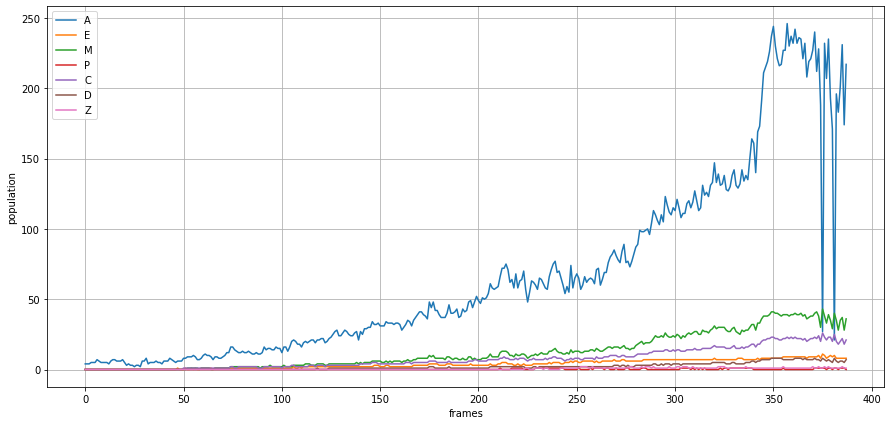

In [11]:
plt.rcParams['figure.figsize'] = 15, 7
                                    
plot = model.create_population_plot_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/embryo_timelapse.mov", 
                                               save_plot= True, 
                                               plot_name= "sample_preds/plot.jpg", 
                                               ignore_last_n_frames= 0 
                                               )
plot.grid()
plot.show()

## Using the pre-trained GAN to synthetic images of embryos 

In [12]:
generator = embryo_generator_model()

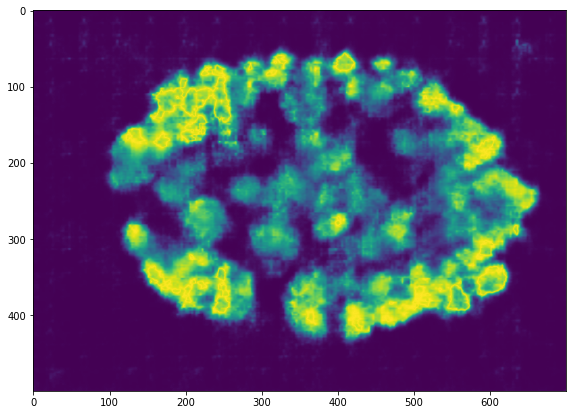

In [13]:
gen_image = generator.generate()  ## returns a 2d numpy array 
plt.imshow(gen_image)
plt.show()

## Bulk generation using the GAN 

All the generated images get saved into the folder `foldername`

generating images :: 100%|██████████| 20/20 [00:01<00:00, 13.56it/s]


Saved  20  images in generated_images


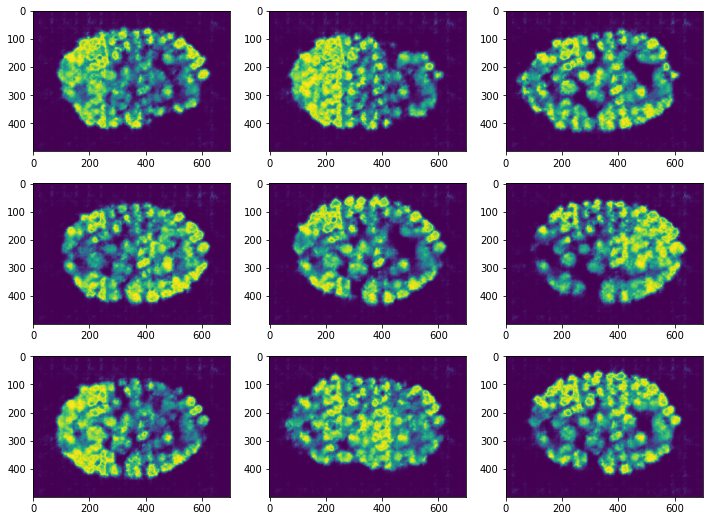

In [14]:
generator.generate_n_images(n = 20, 
                            foldername= "generated_images", 
                            image_size= (700,500)  ## (width,height)
                            )

fig, ax = plt.subplots(3,3, figsize = (12,9))

image_paths = os.listdir("generated_images")
for i in range(9):
    image = cv2.imread("generated_images/" + image_paths[i], 0)
    ax.flat[i].imshow(image)


## Segmenting the C. elegans embryo 

In [15]:
segmentor = cell_membrane_segmentor()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Segmenting an image 

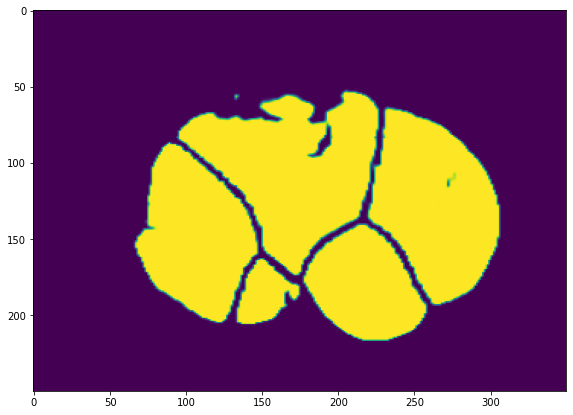

In [16]:
seg_pred = segmentor.predict(image_path = "devolearn/devolearn/tests/sample_data/images/seg_sample.jpg", centroid_mode =False )
plt.imshow(seg_pred)
plt.show()

### Segmenting and extracting the centroids 

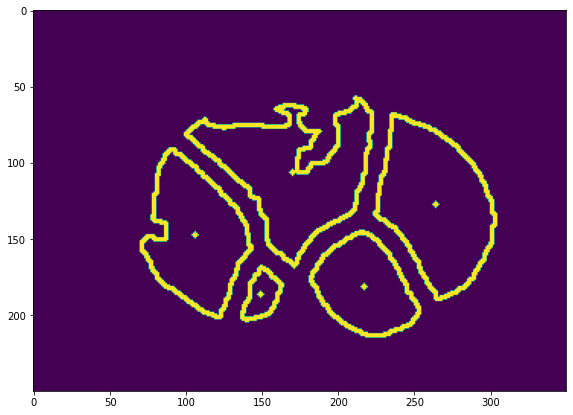

In [17]:
seg_pred, centroids = segmentor.predict(image_path = "devolearn/devolearn/tests/sample_data/images/seg_sample.jpg", centroid_mode = True)
plt.imshow(seg_pred)
plt.show()

# Frame by frame segmentation from video files

All the segmented frames get saved into the folder `save_folder`

In [18]:
filenames = segmentor.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/seg_sample.mov", 
                                         centroid_mode = False, 
                                         save_folder = "segmented_images"
                                         )

saving predictions: 100%|██████████| 421/421 [01:21<00:00,  5.16it/s]


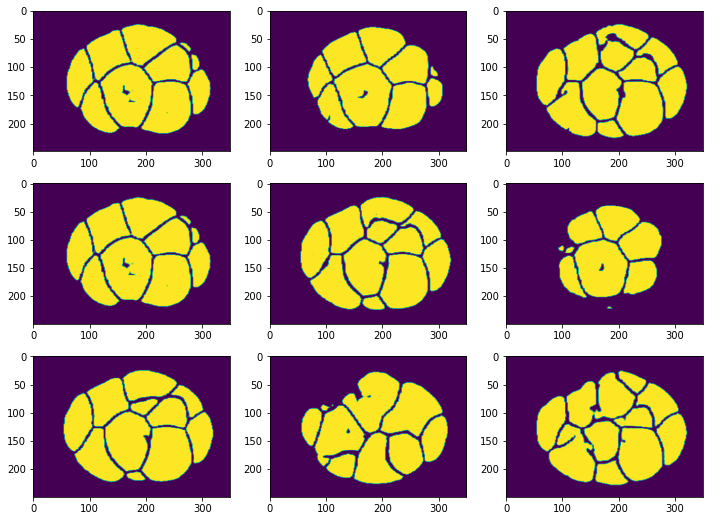

In [19]:
fig, ax = plt.subplots(3,3, figsize = (12,9))

segmented_image_paths = os.listdir("segmented_images")
for i in range(9):
    image = cv2.imread("segmented_images/" + segmented_image_paths[i], 0)
    ax.flat[i].imshow(image)

### Segmenting from a video and saving the centroids into a CSV file 



In [20]:
df = segmentor.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/seg_sample.mov", 
                                  centroid_mode = True, 
                                  save_folder = "centroid")
df.to_csv("centroids.csv")

saving predictions: 100%|██████████| 421/421 [01:18<00:00,  5.34it/s]


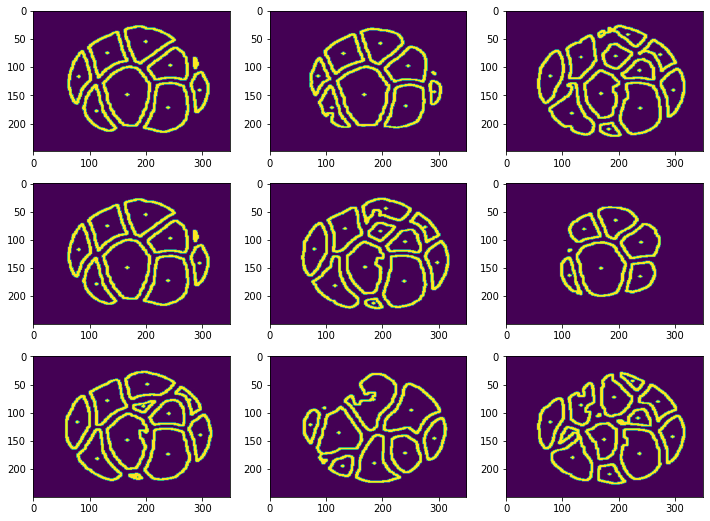

In [21]:
fig, ax = plt.subplots(3,3, figsize = (12,9))

segmented_image_paths = os.listdir("centroid")
for i in range(9):
    image = cv2.imread("centroid/" + segmented_image_paths[i], 0)
    ax.flat[i].imshow(image)

## Run tests (optional)

In [22]:
import devolearn
os.path.dirname(devolearn.__file__) + "/" + "tests" + "/" + "test.py"
!python /content/devolearn/devolearn/tests/test.py

saving predictions: 100% 421/421 [01:17<00:00,  5.46it/s]
saving predictions: 100% 421/421 [01:17<00:00,  5.40it/s]
generating images :: 100% 1/1 [00:00<00:00, 13.75it/s]
Saved  1  images in /content/devolearn/devolearn/tests/generated_images
.skipped possible corrupt frame number :  389
Predicting from video file:  :: 100% 389/389 [00:42<00:00,  9.18it/s]
skipped possible corrupt frame number :  389
Predicting from video file:  :: 100% 389/389 [00:41<00:00,  9.46it/s]
.
----------------------------------------------------------------------
Ran 4 tests in 244.566s

OK
